# Exploratory Analysis

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.getOrCreate()

In [4]:
data_path = '../Data'
file_path = data_path + '/utilization.csv'

In [5]:
df = spark.read.format('csv').options(header=False, inferSchema=True).load(file_path)

In [6]:
df.show(1)

+-------------------+---+----+----+---+
|                _c0|_c1| _c2| _c3|_c4|
+-------------------+---+----+----+---+
|03/05/2019 08:06:14|100|0.57|0.51| 47|
+-------------------+---+----+----+---+
only showing top 1 row



In [9]:
# rename columns
df = df.withColumnRenamed('_c0', 'event_datetime')\
    .withColumnRenamed('_c1', 'server_id')\
    .withColumnRenamed('_c2', 'cpu_utilization')\
    .withColumnRenamed('_c3', 'free_memory')\
    .withColumnRenamed('_c4', 'session_count')

In [11]:
df.show(5)

+-------------------+---------+---------------+-----------+-------------+
|     event_datetime|server_id|cpu_utilization|free_memory|session_count|
+-------------------+---------+---------------+-----------+-------------+
|03/05/2019 08:06:14|      100|           0.57|       0.51|           47|
|03/05/2019 08:11:14|      100|           0.47|       0.62|           43|
|03/05/2019 08:16:14|      100|           0.56|       0.57|           62|
|03/05/2019 08:21:14|      100|           0.57|       0.56|           50|
|03/05/2019 08:26:14|      100|           0.35|       0.46|           43|
+-------------------+---------+---------------+-----------+-------------+
only showing top 5 rows



In [15]:
df.count()

500000

--------

# 1) Exploratory Data Analysis with Spark API

# Describe the data

In [16]:
df.describe().show()

+-------+-------------------+------------------+-------------------+-------------------+------------------+
|summary|     event_datetime|         server_id|    cpu_utilization|        free_memory|     session_count|
+-------+-------------------+------------------+-------------------+-------------------+------------------+
|  count|             500000|            500000|             500000|             500000|            500000|
|   mean|               null|             124.5| 0.6205177399999874|  0.379128099999989|          69.59616|
| stddev|               null|14.430884120553118|0.15875173872912948|0.15830931278376223|14.850676696352853|
|    min|03/05/2019 08:06:14|               100|               0.22|                0.0|                32|
|    max|04/09/2019 01:22:46|               149|                1.0|               0.78|               105|
+-------+-------------------+------------------+-------------------+-------------------+------------------+



# Correlation

In [17]:
df.stat.corr('cpu_utilization', 'free_memory')

-0.47047715730807027

In [18]:
df.stat.corr('cpu_utilization', 'session_count')

0.5026799454107753

In [19]:
df.stat.corr('free_memory', 'session_count')

-0.5008320848876565

# Most Frequently Occuring Items or Values

In [21]:
df.stat.freqItems(['server_id', 'session_count']).show()

+--------------------+-----------------------+
| server_id_freqItems|session_count_freqItems|
+--------------------+-----------------------+
|[146, 137, 101, 1...|   [92, 101, 83, 104...|
+--------------------+-----------------------+



# Sampling

In [23]:
sample_df = df.sample(withReplacement=False, fraction=0.2)

In [24]:
sample_df.count()

100297

-------

# 2) Exploratory Data Analysis with Spark SQL

In [12]:
# create view first, so that we can perform SQL querying later

df.createOrReplaceTempView('vw_utilization')

# Describe data

In [32]:

results = spark.sql('SELECT server_id, min(cpu_utilization), max(cpu_utilization), stddev(cpu_utilization)\
                              FROM vw_utilization\
                              GROUP BY server_id')

In [33]:
results.show()

+---------+--------------------+--------------------+-----------------------+
|server_id|min(cpu_utilization)|max(cpu_utilization)|stddev(cpu_utilization)|
+---------+--------------------+--------------------+-----------------------+
|      148|                0.54|                0.94|    0.11451712518744131|
|      137|                0.54|                0.94|    0.11526245077758812|
|      133|                0.55|                0.95|    0.11534006553263144|
|      108|                0.55|                0.95|    0.11563100171171926|
|      101|                 0.6|                 1.0|    0.11651726263197697|
|      115|                0.44|                0.84|    0.11569664615015006|
|      126|                0.48|                0.88|    0.11542612970702051|
|      103|                0.56|                0.96|    0.11617507884178278|
|      128|                0.38|                0.78|     0.1153254132405078|
|      122|                0.43|                0.83|    0.11563

# Bucketing (bins)

### Create buckets

In [35]:
spark.sql('SELECT server_id, FLOOR(cpu_utilization * 100 / 10) AS bucket\
              FROM vw_utilization').show()

+---------+------+
|server_id|bucket|
+---------+------+
|      100|     5|
|      100|     4|
|      100|     5|
|      100|     5|
|      100|     3|
|      100|     4|
|      100|     5|
|      100|     4|
|      100|     5|
|      100|     5|
|      100|     3|
|      100|     6|
|      100|     6|
|      100|     5|
|      100|     2|
|      100|     4|
|      100|     4|
|      100|     6|
|      100|     4|
|      100|     5|
+---------+------+
only showing top 20 rows



### We want to know how many times data belonged to the specific bucket.

In [38]:
results = spark.sql('SELECT FLOOR(cpu_utilization * 100 / 10) AS bucket, COUNT(*) AS frequency \
              FROM vw_utilization \
              GROUP BY bucket \
              ORDER BY bucket \
              ')

In [39]:
results.show()

+------+---------+
|bucket|frequency|
+------+---------+
|     2|     8186|
|     3|    37029|
|     4|    68046|
|     5|   104910|
|     6|   116725|
|     7|    88242|
|     8|    56598|
|     9|    20207|
|    10|       57|
+------+---------+



In [40]:
type(results)

pyspark.sql.dataframe.DataFrame

# Visualization of data

In [62]:
# convert to pandas df
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
pd_df = results.toPandas()

In [64]:
pd_df.head()

,bucket,frequency
0,2,8186
1,3,37029
2,4,68046
3,5,104910
4,6,116725


In [65]:
pd_df.dtypes

bucket       int64
frequency    int64
dtype: object

In [78]:
pd_df['bucket'] = pd_df['bucket'].astype('category')

In [79]:
# converted to category and marked as already ordered so that they can be indexed
pd_df['bucket'] = pd_df['bucket'].cat.as_ordered()

In [80]:
pd_df.dtypes

bucket       category
frequency       int64
dtype: object

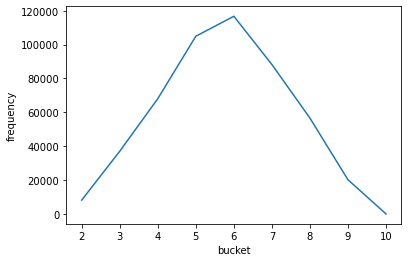

In [84]:
sns.lineplot(x=pd_df['bucket'], y=pd_df['frequency']);